## Sequence-to-Sequence Transformer Model
#### ELEC-ENG 435: Final Project
Yemi Kelani


Training data was sourced from [huggingface](https://huggingface.co/datasets/dair-ai/emotion)

---

##### **Background and Motivation**
Natural Language Processing is a powerful tool that allows machines to process and understand human speech. Consequently it has a wide array of applications ranging from sentiment analysis to text generation and more. Open AI’s ChatGPT alone has managed to amass over one hundred million users within two months of launching. With companies like Bing and Google racing to incorporate NLP AI into their products, it’s clear that this branch of machine learning is here to stay.

##### **Project Goals and Objectives**
I aim to implement a sequence-to-sequence model using pytorch, a popular deep learning framework. Given that such a model will necessarily take time to adequately train, I am more concerned with understanding and implementing the fundamental elements of a sequence-to-sequence model (encoder, decoder, attention, etc.) as opposed to maximizing its overall performance.

I'll be implementing the transformer model, and necessary equations, described in the popular "*Attention is all you need" [(Vaswani et al 2017)](https://arxiv.org/pdf/1706.03762.pdf)* research paper.


I will then train the model on the [Emotion](https://huggingface.co/datasets/dair-ai/emotion) dataset and record its accuracy over a few epochs. The emotion dataset maps pieces of text to labels indicating their classified emotion. As I mentioned in the project proposal and above, the purpose of this project is to better understand transformers and their base components by implementing one from scratch, not maximize the performance of the model on a given task. This allows me to keep the scope of the project reasonable.

---

In [178]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

# torch config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---
#### **Transformer Model**

Transformers are sequence-to-sequence models which utilize self-attention and are comprised of two primary components: an encoder and a decoder. Both components contain similar base operations which can be viewed in the diagram below. Notable elements include: Context Embedding, Positional Encoding, Multi-Head Attention, Feed Forward Neural Network, and Normalization.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" width="350" height="475">

Image source: (Vaswani et al 2017, Page 3)

In [13]:
class Transformer(nn.Module):
  def __init__(self, ec_vocab_size, dc_vocab_size, output_size, embedding_size, 
               hidden_size, num_heads=1, max_sequence_length=128, dropout=0.1, 
               num_layers=1):
    super(Transformer, self).__init__()
    self.embedding_encoder = nn.Embedding(ec_vocab_size, embedding_size)
    self.embedding_decoder = nn.Embedding(dc_vocab_size, embedding_size)
    
    # positionally encode with custom classes
    self.pe_encoder = PositionalEncoder(embedding_size, max_sequence_length)
    self.pe_decoder = PositionalEncoder(embedding_size, max_sequence_length)

    # init encoder, decoder layers
    self.encoder_layers = nn.ModuleList([
        EncoderLayer(embedding_size, hidden_size, num_heads, dropout)
        for _ in range(num_layers)
    ])
    self.decoder_layers = nn.ModuleList([
        DecoderLayer(embedding_size, hidden_size, num_heads, dropout)
        for _ in range(num_layers)
    ])

    # linear layer, no softmax
    self.linear = nn.Linear(embedding_size, output_size)

  def forward(self, encoder_input, decoder_input, encoder_mask=None, 
              decoder_mask=None):
    encoder_input = self.embedding_encoder(encoder_input)
    encoder_input = self.pe_encoder(encoder_input)

    decoder_input = self.embedding_decoder(decoder_input)
    decoder_input = self.pe_decoder(decoder_input)

    # process inputs through layers
    encoder_output = encoder_input
    for layer in self.encoder_layers:
      encoder_output = layer(encoder_output, encoder_mask)

    decoder_output = decoder_input
    for layer in self.decoder_layers:
      decoder_output = layer(decoder_output, encoder_output, 
                             encoder_mask, decoder_mask)

    logits = self.linear(decoder_output)
    return logits


##### **Method and Results**
I disguised my classification task as a text generation task where the vocabulary of the model's generations was limited to the tokens used to classify the features. For example, the vocabulary consisted of the tokens 'sadness' and 'joy'. I then passed the same encoded inputs to both the encoder and decoder and generated results over the vocabulary to classify them. No attention masks were used. All code is posted in the Appendix.

I was able to achieve an **accuracy of 72.98%** on the training dataset which is much higher than a baseline of random guessing (which is 16% given that there are 6 total classes). Cost and Accuracy curves can be viewed in the Appendix.

##### **Obstacles**
Training this transformer was a nightmare. I spent hours configuring the parameters, testing different loss criterions, fixing and debugging errors, and more. A bit difficulty came in addressing the lack of attention masks used for training. I used a lot of '[PAD]' tokens to ensure the transformer could train in batches of the same sequence length. This also meant that the model was learning representations for these tokens where it should've ignored them. Ultimately, I was unable to mitigate its effects and just had to reinitialize the weights of the model until it could train well.

Aside from that, this project was a large undertaking for me. I implemented the classes from scratch, save multi-head attention, embedding, and Layernorm. I had initially planned to do text generation with this model, however, preprocessing a large corpus, implementing beam search, and other factors would have made this project's scope too large.

##### **Conclusion**
From reading the "Attention is all you need" paper to constructing the classes for the model's components, I feel as though I better understand transformers and how they work. If I were to further iterate upon this project, I would try focusing on text generation and implementing generating schemes like beam search or controlled generation. I would also implement comprehensive metrics such as Perplexity and the BLUE score.

##### **Appendix**

Code for the PositionalEncoder, EncoderLayer, DecoderLayer, training, etc. can be viewed below.

---

In [14]:
class PositionalEncoder(nn.Module):
  def __init__(self, embedding_size, max_sequence_length=128, dropout=0.0):
    super(PositionalEncoder, self).__init__()
    
    # dropout
    self.dropout = nn.Dropout(dropout)

    # positional encoding
    pe = torch.zeros(max_sequence_length, embedding_size)
    for position in range(max_sequence_length):
      for i in range(0, embedding_size, 2):
        theta = position / (10000 ** ((2 * i) / embedding_size))
        pe[position, i] = np.sin(theta)
        pe[position, i + 1] = np.cos(theta)

    # pack it together (add dimension)
    pe = pe.unsqueeze(0)
    
    # the positional encoding should not be trained by
    # the optimizer, but should be saved to the dict for
    # loading/reloading, so register buffer is used here
    self.register_buffer('pe', pe)
  
  def forward(self, x):
    # add positional encoding to input embeddings (x)
    x = x + self.pe[:, :x.size(1)] # shape (1, seq_len, embedding_size)
    return self.dropout(x)

In [15]:
class EncoderLayer(nn.Module):
  def __init__(self, embedding_size, hidden_size, num_heads, dropout=0.1):
    super(EncoderLayer, self).__init__()

    # multi-head attention, dropout
    self.multihead_attention = nn.MultiheadAttention(embedding_size, num_heads)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)

    # layer normalization
    self.norm_layer_1 = nn.LayerNorm(embedding_size)
    self.norm_layer_2 = nn.LayerNorm(embedding_size)

    # feed forward specified by paper
    self.feedforward = nn.Sequential(
        nn.Linear(embedding_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, embedding_size)
    )

  def forward(self, x, encoder_mask=None):
    attn_output, _ = self.multihead_attention(x, x, x, attn_mask=encoder_mask)
    out = x + self.dropout_1(attn_output) # residual connection
    out = self.norm_layer_1(out)

    out = self.feedforward(out)
    out = out + self.dropout_2(out) # residual connection
    out = self.norm_layer_2(out)

    return out

In [16]:
class DecoderLayer(nn.Module):
  def __init__(self, embedding_size, hidden_size, num_heads, dropout=0.1):
    super(DecoderLayer, self).__init__()
    
    # multi-head attention, dropout
    self.multihead_attention = nn.MultiheadAttention(embedding_size, num_heads)
    self.masked_multihead_attention = nn.MultiheadAttention(embedding_size, 
                                                            num_heads)
    self.dropout_1 = nn.Dropout(dropout)
    self.dropout_2 = nn.Dropout(dropout)
    self.dropout_3 = nn.Dropout(dropout)

    # layer normalization
    self.norm_layer_1 = nn.LayerNorm(embedding_size)
    self.norm_layer_2 = nn.LayerNorm(embedding_size)
    self.norm_layer_3 = nn.LayerNorm(embedding_size)

    # feed forward specified by paper
    self.feedforward = nn.Sequential(
        nn.Linear(embedding_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, embedding_size)
    )
  
  def forward(self, x, encoder_output, encoder_mask=None, decoder_mask=None):
    attn_output, _ = self.multihead_attention(x, x, x, attn_mask=decoder_mask)
    out = x + self.dropout_1(attn_output) # residual connection
    out = self.norm_layer_1(out)

    attn_output, _ = self.masked_multihead_attention(
        out, encoder_output, encoder_output, attn_mask=encoder_mask)
    out = out + self.dropout_2(attn_output) # residual connection
    out = self.norm_layer_2(out)

    out = self.feedforward(out)
    out = out + self.dropout_3(out)
    out = self.norm_layer_3(out)

    return out

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip install -q apache_beam mwparserfromhell
!pip install -q datasets
from datasets import load_dataset

!pip install -q transformers
from transformers import AutoTokenizer, AutoConfig

import time
import numpy as np
from tqdm import tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.14 requires dill>=0.3.6, but you have dill 0.3.1.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [507]:
# parameters
EMBEDDING_SIZE = 100
NUM_HEADS      = 1
NUM_LAYERS     = 1
HIDDEN_SIZE    = 100
DROPOUT        = 0.15
MAX_SEQ_LEN    = 64
LR             = 0.0001
BATCH_SIZE     = 128
EPOCHS         = 10

# emotions classes
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# helper functions
def init_model_weights(model: nn.Module):
  for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

CONFIG_PATH = "/content/drive/MyDrive/EE 435/config.json"
TOKENIZER_PATH = "/content/drive/MyDrive/EE 435/emotion-tokenizer.json"
def get_tokenizer(dataset: Dataset, save_path="", load_path="", config_path=""):
  if load_path != "":
    tokenizer = AutoTokenizer.from_pretrained(
        load_path, 
        config=AutoConfig.from_pretrained(config_path))
    return tokenizer
  
  tokenizer = AutoTokenizer.from_pretrained("gpt2")
  def tokenize_data(data):
      return tokenizer(data["text"], truncation=True, max_length=512)
  dataset = dataset.map(tokenize_data, batched=True)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  tokenizer.save_pretrained(save_path)
  return tokenizer

def train(model: nn.Module, dataset: Dataset, epochs: int, batch_size: int):
  model.train()

  cost = []
  accuracy = []

  for epoch in tqdm(range(epochs)):

    count = 0
    correct = 0
    epoch_loss = 0 

    for i in range(0, dataset.__len__(), batch_size):
      batch = dataset[i]

      text = list(batch[:, 0])
      labels = batch[:, 1].astype(int)
      labels = torch.Tensor(labels).type(torch.LongTensor).to(device)

      encoding = tokenizer(text, truncation=True, max_length=MAX_SEQ_LEN, 
                     padding="max_length", return_attention_mask=False, 
                     return_tensors="pt")

      encoding['input_ids'] = encoding['input_ids'].to(device)

      optimizer.zero_grad()

      out = model.forward(
          encoding['input_ids'],
          encoding['input_ids']
      )
      out = torch.mean(out, dim=1)

      probabilities = F.softmax(out, dim=1)
      predicted_labels = torch.argmax(probabilities, dim=1)

      loss = criterion(out, labels)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()

      count += batch_size
      for i, l in enumerate(labels): 
        if predicted_labels[i] == labels[i]:
          correct += 1
    
    cost.append(epoch_loss/count)
    accuracy.append(correct/count)
    print(f"epoch: {epoch}, accuracy: {accuracy[-1]}, loss: {cost[-1]}")
  
  return cost, accuracy

In [277]:
class BalancedEmotionDataset(Dataset):
  def __init__(self, data, batch_size):
    super(BalancedEmotionDataset, self).__init__()
    self.data = self.balance_classes(data)
    self._len = self.data.shape[0]
    self.batch_size = batch_size
  
  def __len__(self):
    return self._len
  
  def __getitem__(self, i):
    return self.data[i:i+self.batch_size]

  def balance_classes(self, dataset: Dataset):
    class_records = {
        0: [[], 0], 1: [[], 0], 2: [[], 0], 3: [[], 0], 4: [[], 0], 5: [[], 0]
    }

    max_count = 30000
    for i in range(len(dataset['train'])):
      label = dataset['train'][i]['label']
      text  = dataset['train'][i]['text']

      if class_records[label][1] < max_count:
        class_records[label][0].append([text, label])
        class_records[label][1] += 1
    
    grouped = (
        class_records[0][0],
        class_records[1][0],
        class_records[2][0],
        class_records[3][0],
        class_records[4][0],
        class_records[5][0]
    )

    data = np.concatenate(grouped, axis=0)
    np.random.shuffle(data)
    return data

In [278]:
raw_dataset = load_dataset("emotion", "unsplit")
dataset = BalancedEmotionDataset(raw_dataset, BATCH_SIZE)

  0%|          | 0/1 [00:00<?, ?it/s]

In [289]:
tokenizer = get_tokenizer(raw_dataset, save_path=TOKENIZER_PATH) # create/save
# tokenizer = get_tokenizer(dataset, 
#                           load_path=TOKENIZER_PATH, 
#                           config_path=CONFIG_PATH) # load tokenizer

In [22]:
# !rm /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-c2ca0c84ab5b810e.arrow

In [503]:
ec_vocab_size = tokenizer.vocab_size + 1
dc_vocab_size = tokenizer.vocab_size + 1
output_size = len(class_names)

model = Transformer(
    ec_vocab_size, dc_vocab_size,
    output_size, EMBEDDING_SIZE, 
    HIDDEN_SIZE, NUM_HEADS, MAX_SEQ_LEN, 
    DROPOUT, NUM_LAYERS)

init_model_weights(model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

In [508]:
cost, acc = train(model, dataset, EPOCHS, BATCH_SIZE)

 10%|█         | 1/10 [00:37<05:33, 37.11s/it]

epoch: 0, accuracy: 0.1932093677269201, loss: 0.013850767670460826


 20%|██        | 2/10 [01:14<04:58, 37.36s/it]

epoch: 1, accuracy: 0.3186578743211792, loss: 0.013144250365972658


 30%|███       | 3/10 [01:50<04:17, 36.82s/it]

epoch: 2, accuracy: 0.43494230023273855, loss: 0.012084872969061345


 40%|████      | 4/10 [02:41<04:13, 42.18s/it]

epoch: 3, accuracy: 0.4903874127230411, loss: 0.01139360302994194


 50%|█████     | 5/10 [03:33<03:49, 45.92s/it]

epoch: 4, accuracy: 0.5321773176881304, loss: 0.010775039075094198


 60%|██████    | 6/10 [04:14<02:57, 44.27s/it]

epoch: 5, accuracy: 0.574088440651668, loss: 0.01013847293738273


 70%|███████   | 7/10 [05:11<02:25, 48.40s/it]

epoch: 6, accuracy: 0.6198421741660202, loss: 0.009455174406379161


 80%|████████  | 8/10 [05:55<01:33, 46.96s/it]

epoch: 7, accuracy: 0.6611714507370055, loss: 0.008772961467669234


 90%|█████████ | 9/10 [06:32<00:43, 43.85s/it]

epoch: 8, accuracy: 0.693179063227308, loss: 0.00817949596728878


100%|██████████| 10/10 [07:08<00:00, 42.89s/it]

epoch: 9, accuracy: 0.7298293250581847, loss: 0.007533648084918481


In [511]:
# SAVE MODEL
TRANSFORMER_SAVE = "/content/drive/MyDrive/EE 435/TransformerModelEmotion.pt"
torch.save(model.state_dict(), TRANSFORMER_SAVE)

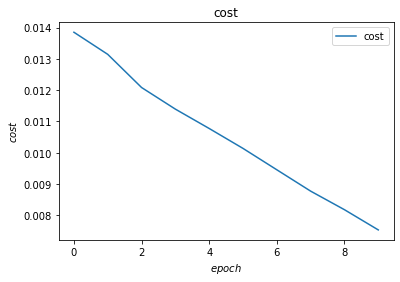

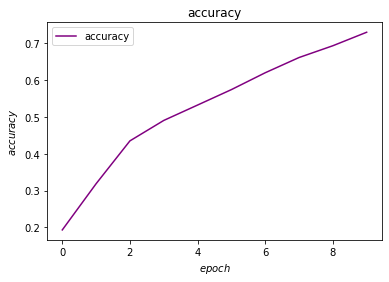

In [510]:
import matplotlib.pyplot as plt
k_axis = [k for k in range(len(cost))]
plt.plot(k_axis, cost, label=f"cost")
plt.title("cost")
plt.xlabel("$epoch$")
plt.ylabel("$cost$")
plt.legend()
plt.show()

plt.plot(k_axis, acc, label=f"accuracy", c="purple")
plt.title("accuracy")
plt.xlabel("$epoch$")
plt.ylabel("$accuracy$")
plt.legend()
plt.show()